In [1]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.display.max_columns = None
from pybaseball import batting_stats, pitching_stats, cache, playerid_lookup, statcast_batter, statcast_pitcher, statcast, batting_stats_range
import math
import sqlite3
cache.enable()
cache.config.cache_type='csv'
cache.config.save()


In [ ]:
conn = sqlite3.connect('fantasy_data.db')
conn.create_function('sqrt', 1, math.sqrt)
cursor = conn.cursor()

In [2]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [3]:
n_teams = 12
tm_players = 23
tm_dollars = 260
player_split = .67
pitcher_split = 1 - player_split
tot_dollars = n_teams * tm_dollars
tot_players = n_teams * tm_players
tot_hitters = n_teams * 14
tot_pitchers = n_teams * 9

drafted_by_pos = {
    'C':n_teams,
    '1B':round(n_teams*1.5),
    '2B':round(n_teams*1.5),
    '3B':math.floor(n_teams*1.5),
    'SS':math.floor(n_teams*1.5),
    'OF':n_teams*5,
    'MI':n_teams,
    'CI':n_teams,
    'DH':n_teams*2, 
    'P':n_teams*9,
    'SP':round(n_teams*6.5),
    'RP':math.floor(n_teams*2.5),
}

In [4]:
def load_data(kind):
    if kind=='proj':
        atc = pd.read_csv('data/2022-atc-proj-h.csv', encoding="latin-1")
        dc = pd.read_csv('data/2022-dc-proj-h.csv', encoding="latin-1")
        steamer = pd.read_csv('data/2022-steamer-proj-h.csv', encoding="latin-1")
        zips = pd.read_csv('data/2022-zips-proj-h.csv', encoding="latin-1")
        val_h = pd.read_csv('data/2022-fangraphs-auction-calculator-h.csv')
        val_h.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
        cbs = pd.read_csv('data/2022-cbs-values.csv', encoding="latin-1")
        h = atc.append(dc).append(steamer).append(zips).sort_values('playerid')
        h = h.merge(val_h[['playerid', 'Pos', 'Dollars']]).merge(cbs[['playerid', 'CBS']], on='playerid', how='left')
        h.drop(columns=['wOBA', 'CS', 'Fld', 'BsR', 'ADP'],inplace=True)
        h['Primary_Pos'] = h.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
        proj = pd.pivot_table(h, index='playerid', values=['G', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'SB'], aggfunc='mean').merge(h[['playerid', 'Name', 'Team', 'Pos', 'Primary_Pos', 'Dollars', 'CBS']], on='playerid', how='inner').drop_duplicates()
        proj['sorter'] = proj['HR']+proj['R']+proj['RBI']+proj['H']+proj['SB']
        proj['BA'] = proj['H']/proj['AB']
        proj = proj.drop_duplicates(subset='playerid')

        atc = pd.read_csv('data/2022-atc-proj-p.csv', encoding="latin-1")
        dc = pd.read_csv('data/2022-dc-proj-p.csv', encoding="latin-1")
        steamer = pd.read_csv('data/2022-steamer-proj-p.csv', encoding="latin-1")
        zips = pd.read_csv('data/2022-zips-proj-p.csv', encoding="latin-1")
        val_p = pd.read_csv('data/2022-fangraphs-auction-calculator-p.csv')
        val_p.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
        p = atc.append(dc).append(steamer).append(zips).sort_values('playerid')
        p = p.merge(val_p[['playerid', 'Pos', 'Dollars']]).merge(cbs[['playerid', 'CBS']], on='playerid', how='left')
        p.rename(columns={'H':'HA'},inplace=True)
        p['Sv+Hld'] = p['SV']+p['HLD']
        p['Primary_Pos'] = p['Pos'].apply(lambda x: ', '.join(x.split('/')))

        pproj = pd.pivot_table(p, index='playerid', values=['GS', 'G', 'IP', 'ER', 'HA', 'SO', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld'], aggfunc='mean').merge(p[['playerid', 'Name', 'Team', 'Pos', 'Dollars', 'CBS']], on='playerid', how='inner').drop_duplicates()
        pproj['sorter'] = pproj['SO']+(pproj['Sv+Hld']*4)+pproj['W']
        pproj['Primary_Pos'] = pproj.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
        #proj = proj.append(pproj)
        pproj['IP'].fillna(0, inplace=True)
        for i in ['PA', 'AB', 'G', 'H', 'HR', 'R', 'RBI', 'SB']:
            proj[i].fillna(0,inplace=True)
            proj[i] = proj[i].apply(lambda x: int(x))
        for i in ['GS', 'G', 'HA', 'SO', 'ER', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld']:
            pproj[i].fillna(0,inplace=True)
            pproj[i] = pproj[i].apply(lambda x: int(x))
        pproj['ERA'] = pproj['ER']/pproj['IP']*9
        pproj['WHIP'] = (pproj['HA']+pproj['BB'])/pproj['IP']
        pproj = pproj.drop_duplicates(subset='playerid')

        return proj.sort_values('Dollars', ascending=False), pproj.sort_values('Dollars', ascending=False)
    else:
        #h = batting_stats(datetime.now().year, qual=1)
        h = pd.read_csv('data\\2022-final-stats-h.csv')
        h = h[h['PA']>0]
        stat_list = ['IDfg', 'Name', 'Team', 'G', 'AB', 'PA', 'H', 'HR', 'R', 'RBI', 'BB', 'IBB', 'HBP', 'SF', 'SH', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
        all_pos = pd.DataFrame()
        for pos in ['1B', '2B', 'SS', '3B', 'OF', 'C', 'DH']:
            temp = batting_stats(2022, qual=1, position=pos)[stat_list]
            temp['Pos'] = pos
            all_pos = all_pos.append(temp)
        h = all_pos.groupby('IDfg').agg({'Name':'first', 'Team':'first', 'G':'first', 'AB':'first', 'PA':'first', 'H':'first', 'HR':'first', 'R':'first', 'RBI':'first', 
                                                     'BB':'first', 'IBB':'first', 'HBP':'first', 'SF':'first', 'SH':'first', 'SB':'first', 'CS':'first', 'AVG':'first', 'OBP':'first',
                                                     'SLG':'first', 'OPS':'first', 'Pos':'/'.join})
        h['Primary_Pos'] = h.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
        h = h.reset_index()
        h.rename(columns={'IDfg':'playerid'}, inplace=True)
        h['playerid'] = h['playerid'].astype(str)
        
        #p = pitching_stats(datetime.now().year, qual=0)[['IDfg', 'Name', 'Team', 'IP', 'W', 'G', 'GS', 'SV', 'H', 'R', 'ER', 'BB', 'IBB', 'HBP', 'SO', 'HLD', 'Start-IP', 'Relief-IP']]
        p = pd.read_csv('data\\2022-final-stats-p.csv')
        p.rename(columns={'H':'HA', 'IDfg':'playerid'}, inplace=True)
        p['Sv+Hld'] = p['SV']+p['HLD']
        p['sorter'] = p['SO']+(p['Sv+Hld']*4)+p['W']
        #p.loc[(p['Start-IP'].notna()) & (p['Relief-IP'].isna()), 'Pos'] = 'SP'
        #p.loc[(p['Start-IP'].isna()) & (p['Relief-IP'].notna()), 'Pos'] = 'RP'
        #p['Pos'].fillna('SP/RP', inplace=True)
        #p['Primary_Pos'] = p.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
        p['playerid'] = p['playerid'].astype(str)
        return h, p

def calc_z(x, stat):
    z = (x - drafted[stat].mean()) / drafted[stat].std()
    return z

def find_primary_pos(p):
    pos_list = p.split('/')
    pos_hierarchy = ['C', '3B', '2B', '1B', 'SS', 'OF', 'DH', 'SP', 'RP', 'P']
    for i in pos_hierarchy:
        if i in pos_list:
            return i

def owners(conv):
    df = pd.read_sql('players', engine)
    owners_df = df.groupby('Owner').agg({'Name':'count', 'Paid':'sum', 'z':'sum', 'H':'sum', 'AB':'sum', 'HR':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'W':'sum', 'Sv+Hld':'sum', 'SO':'sum'}).reset_index()
    owners_df.rename(columns={'Name':'Drafted'},inplace=True)
    owners_df['$/unit'] = owners_df['Paid']/owners_df['z']
    owners_df['$ Left'] = tm_dollars - owners_df['Paid']
    owners_df['$ Left / Plyr'] = owners_df['$ Left'] / (tm_players -owners_df['Drafted'])
    owners_df['Cash Sitch'] = owners_df['$ Left / Plyr'] / (((tot_dollars - owners_df.Paid.sum()) + owners_df['Paid']) / ((tot_players - owners_df.Drafted.sum()) + owners_df['Drafted']))
    owners_df['Value'] = (owners_df['z']*conv)-owners_df['Paid']
    owners_df['BA'] = owners_df['H']/owners_df['AB']
    owners_df['Pts'] = 0
    for i in ['BA', 'HR', 'R', 'RBI', 'SB', 'W', 'Sv+Hld', 'SO']:
        owners_df['Pts'] += owners_df[i].rank()
    owners_df['Rank'] = owners_df['Pts'].rank()
    return df.sort_values('z', ascending=False), owners_df

def check_roster_pos(roster, name, team_name, pos, eligible):
    eligible_at = eligible.split('/')
    eligibility = []
    for p in eligible.split('/'):
        if p=='C':
            eligibility.extend(['C'])
        if p=='1B':
            eligibility.extend(['1B', 'CI'])
        if p=='2B':
            eligibility.extend(['2B', 'MI'])
        if p=='3B':
            eligibility.extend(['3B', 'CI'])
        if p=='SS':
            eligibility.extend(['SS', 'MI'])
        if p=='OF':
            eligibility.extend(['OF1', 'OF2', 'OF3', 'OF4', 'OF5'])
        if p in ['SP', 'RP']:
            eligibility.extend(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'])
        
    eligibility = list(dict.fromkeys(eligibility))
    if 'SP' in eligible_at or 'RP' in eligible_at: 
        pos_list = eligibility
    else:
        pos_list = eligibility+['DH1', 'DH2']
    for p in pos_list:
        if roster.loc[p, team_name]==0:
            roster.loc[p, team_name] = name
            return p
    
    return pos_list

def next_closest_in_tier(df, pos, playerid):
    try:
        i = df[(df['Primary_Pos']==pos) & (df['playerid']==playerid) & (df['Owner'].isna())].index[0]
        val = df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['playerid']==playerid)]['Value'].iloc[0]
        return df[df['playerid']==playerid]['Value'].iloc[0] - df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['Value']<=val)].iloc[1]['Value']
    except:
        return 0
    
def big_board(row, stat):
    # qual_avgs comes from 2019 and 2021 qualified players' averages and stdevs for each stat
    qual_avgs = {'G':[145.0, 10.8], 'PA':[600.4, 59.6], 'AB':[533.4, 53.6], 'H':[143.7, 22.5], 'HR':[24.4, 10.4], 'zlgBA':[0.20, 13.9],
            'R':[82.5, 17.6], 'RBI':[78.9, 19.9], 'SB':[8.6, 8.8], 'AVG':[.269, .026], 'W':[6.1, 4.3], 'GS':[7.6, 13.5], 'Sv+Hld':[12.9, 11.6],
            'ER':[37.3, 23.7], 'IP':[91.2, 53.2], 'SO':[95.7, 57.4], 'BB':[30.2, 15.7], 'HA':[79.7, 50.9], 'zlgERA':[.1235, 89.55], 'zlgWHIP':[-.1512, 17.63368]}
    if stat == 'BA':
        ba_pts = row['H']-(row['AB']*(qual_avgs['H'][0]/qual_avgs['AB'][0]))
        zBA = (ba_pts-qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        #return ((row['AB'] * (((row['H']/row['AB'])-qual_avgs['AVG'][0])/qual_avgs['AVG'][1])) - qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        return zBA
    elif stat=='ERA':
        pts = ((row['ER']*9) - ((row['IP']*qual_avgs['ER'][0]*9)/qual_avgs['IP'][0])) * -1
        zERA = (pts-qual_avgs['zlgERA'][0])/qual_avgs['zlgERA'][1]
        return zERA
    elif stat=='WHIP':
        pts = ((row['HA']+row['BB'])-(row['IP']*((qual_avgs['HA'][0]+qual_avgs['BB'][0])/qual_avgs['IP'][0]))) * -1
        zWHIP = (pts-qual_avgs['zlgWHIP'][0])/qual_avgs['zlgWHIP'][1]
        return zWHIP
    else:
        return (row[stat] - qual_avgs[stat][0]) / qual_avgs[stat][1]

In [17]:
h, p = load_data('cur') # use 'proj' arg for projection info
draft = pd.read_sql('players2022', engine).sort_values('playerid')
h = h.merge(draft[['playerid', 'Primary_Pos', 'z', 'Value', 'Paid', 'Owner']], on='playerid', how='left')
p = p.merge(draft[['playerid', 'Primary_Pos', 'z', 'Value', 'Paid', 'Owner']], on='playerid', how='left')

In [18]:
conv = (tm_dollars/tm_players)*(tot_players/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('\nTotal z:',h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum())
print('\nH/P split:',h[h['z']>0]['z'].sum()/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('Conversion to $:',conv)

h['Val'] = h['z']*conv
p['Val'] = p['z']*conv
p.loc[p['Name']=='Shohei Ohtani', 'playerid'] = 'p19755'


Total z: 697.6385979672483

H/P split: 0.6351177594596997
Conversion to $: 4.472229617298889


In [19]:
b = h.append(p)

In [20]:
df = pd.read_csv('data\\2022-final-stats-h.csv')
df = df[df['PA']>0]

In [21]:
# Get season data for all players with at least 1 PA
qh = batting_stats(datetime.now().year-1, qual=1)
qh['playerid'] = qh['IDfg'].astype(str)
# Consider the player qualified at 502 PA (3.1*162)
qh.loc[qh['PA']>=502, 'Qual'] = 1
qh.Qual.fillna(0,inplace=True)
qh = qh.merge(draft[['playerid', 'Primary_Pos', 'z', 'Value', 'Paid', 'Owner', 'Timestamp']], on='playerid', how='left')

qh['qual_H_mean'] = qh.loc[qh['Qual']==1]['H'].mean()
qh['qual_AB_mean'] = qh.loc[qh['Qual']==1]['AB'].mean()
qh['zBA'] = qh.apply(lambda x: x['H']-(x['AB']*(x['qual_H_mean']/x['qual_AB_mean'])), axis=1)

qual_avgs_h = qh[qh['Qual']==1].agg({'HR':['mean', 'std'], 'R':['mean', 'std'], 'RBI':['mean', 'std'], 'SB':['mean', 'std'], 'PA':['mean', 'std'], 'AB':['mean', 'std'], 
                                              'H':['mean', 'std'], 'zBA':['mean', 'std']})

# Get z-scores for the 5 hitting categories
qh['zAVG'] = qh.apply(lambda x: (x['zBA']-qual_avgs_h['zBA']['mean'])/qual_avgs_h['zBA']['std'], axis=1)
qh['zHR'] = qh.apply(lambda x: (x['HR']-qual_avgs_h['HR']['mean'])/qual_avgs_h['HR']['std'], axis=1)
qh['zR'] = qh.apply(lambda x: (x['R']-qual_avgs_h['R']['mean'])/qual_avgs_h['R']['std'], axis=1)
qh['zRBI'] = qh.apply(lambda x: (x['RBI']-qual_avgs_h['RBI']['mean'])/qual_avgs_h['RBI']['std'], axis=1)
qh['zSB'] = qh.apply(lambda x: (x['SB']-qual_avgs_h['SB']['mean'])/qual_avgs_h['SB']['std'], axis=1)
qh['zTot'] = qh['zAVG'] + qh['zHR'] + qh['zR'] + qh['zRBI'] + qh['zSB']

# Get season data for all pitchers
qp = pitching_stats(datetime.now().year-1, qual=0)
qp['playerid'] = qp['IDfg'].astype(str)
# Consider the player qualified at 48 IP
qp.loc[qp['IP']>=48, 'Qual'] = 1
qp.Qual.fillna(0,inplace=True)
qp['Sv+Hld'] = qp['SV'] + qp['HLD']
qp = qp.merge(draft[['playerid', 'Primary_Pos', 'z', 'Value', 'Paid', 'Owner', 'Timestamp']], on='playerid', how='left')

qp['qual_IP_mean'] = qp.loc[qp['Qual']==1]['IP'].mean()
qp['qual_ER_mean'] = qp.loc[qp['Qual']==1]['ER'].mean()
qp['qual_H_mean'] = qp.loc[qp['Qual']==1]['H'].mean()
qp['qual_BB_mean'] = qp.loc[qp['Qual']==1]['BB'].mean()
qp['zER'] = qp.apply(lambda x: ((x['ER']*9) - ((x['IP']*x['qual_ER_mean']*9)/x['qual_IP_mean']))*-1, axis=1)
qp['zH_BB'] = qp.apply(lambda x: ((x['H']+x['BB']) - (x['IP']*((x['qual_H_mean']+x['qual_BB_mean'])/x['qual_IP_mean']))) * -1, axis=1)

qual_avgs_p = qp[qp['Qual']==1].agg({'W':['mean', 'std'], 'SO':['mean', 'std'], 'Sv+Hld':['mean', 'std'], 'ER':['mean', 'std'], 'IP':['mean', 'std'], 'BB':['mean', 'std'],
                                                          'H':['mean', 'std'], 'zER':['mean', 'std'], 'zH_BB':['mean', 'std']})

qp['zW'] = qp.apply(lambda x: (x['W']-qual_avgs_p['W']['mean'])/qual_avgs_p['W']['std'], axis=1)
qp['zSO'] = qp.apply(lambda x: (x['SO']-qual_avgs_p['SO']['mean'])/qual_avgs_p['SO']['std'], axis=1)
qp['zSv+Hld'] = qp.apply(lambda x: (x['Sv+Hld']-qual_avgs_p['Sv+Hld']['mean'])/qual_avgs_p['Sv+Hld']['std'], axis=1)
qp['zERA'] = qp.apply(lambda x: (x['zER']-qual_avgs_p['zER']['mean'])/qual_avgs_p['zER']['std'], axis=1)
qp['zWHIP'] = qp.apply(lambda x: (x['zH_BB']-qual_avgs_p['zH_BB']['mean'])/qual_avgs_p['zH_BB']['std'], axis=1)
qp['zTot'] = qp['zW'] + qp['zSO'] + qp['zSv+Hld'] + qp['zERA'] + qp['zWHIP']

In [22]:
print('Positional adjustment applied by primary position')
c_adjust = abs(qh[qh['Primary_Pos']=='C'].sort_values('zTot',ascending=False).iloc[drafted_by_pos['C']]['zTot'])
qh.loc[qh['Primary_Pos']=='C', 'Pos_adj'] = c_adjust
ci_adjust = abs(qh[qh['Primary_Pos'].isin(['1B', '3B'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['1B']+drafted_by_pos['3B']]['zTot'])
qh.loc[qh['Primary_Pos'].isin(['1B', '3B']), 'Pos_adj'] = ci_adjust
mi_adjust = abs(qh[qh['Primary_Pos'].isin(['2B', 'SS'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['SS']+drafted_by_pos['2B']]['zTot'])
qh.loc[qh['Primary_Pos'].isin(['2B', 'SS']), 'Pos_adj'] = mi_adjust
of_adjust = abs(qh[qh['Primary_Pos'].isin(['OF', 'DH'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['OF']]['zTot'])
qh.loc[qh['Primary_Pos'].isin(['OF', 'DH']), 'Pos_adj'] = of_adjust

print('C',qh[qh['Primary_Pos']=='C'].sort_values('zTot',ascending=False).iloc[drafted_by_pos['C']]['zTot'])
print('MI',qh[qh['Primary_Pos'].isin(['2B', 'SS'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['1B']+drafted_by_pos['3B']]['zTot'])
print('CI',qh[qh['Primary_Pos'].isin(['1B', '3B'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['SS']+drafted_by_pos['2B']]['zTot'])
print('OF',qh[qh['Primary_Pos'].isin(['OF', 'DH'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['OF']]['zTot'])

sp_adjust = abs(qp[qp['Primary_Pos']=='SP'].sort_values('zTot',ascending=False).iloc[drafted_by_pos['SP']]['zTot'])
qp.loc[qp['Primary_Pos']=='SP', 'Pos_adj'] = sp_adjust
rp_adjust = abs(qp[qp['Primary_Pos']=='RP'].sort_values('zTot',ascending=False).iloc[drafted_by_pos['RP']]['zTot'])
qp.loc[qp['Primary_Pos']=='RP', 'Pos_adj'] = rp_adjust
print('SP',qp[qp['Primary_Pos'].isin(['SP'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['SP']]['zTot'])
print('RP',qp[qp['Primary_Pos'].isin(['RP'])].sort_values('zTot',ascending=False).iloc[drafted_by_pos['RP']]['zTot'])

# Apply Positional adjustment
qh['zTot'] = qh['zTot'] + qh['Pos_adj']
qp['zTot'] = qp['zTot'] + qp['Pos_adj']

Positional adjustment applied by primary position
C -5.207345905464342
MI -4.0544911953776674
CI -2.0265331105809787
OF -5.153823426739079
SP 0.02636613115620265
RP 1.5264060432276125


In [23]:
qual_avgs_h

,HR,R,RBI,SB,PA,AB,H,zBA
mean,20.076923,74.476923,71.838462,8.907692,597.446154,533.169231,138.184615,-4.481885e-15
std,9.636506,16.510845,19.549501,8.823371,57.712340,51.598350,23.088231,1.482485e+01


In [24]:
conv = (tm_dollars/tm_players)*(tot_players/(qh[qh['zTot']>0]['zTot'].sum()+qp[qp['zTot']>0]['zTot'].sum()))
print('\nTotal z:',qh[qh['zTot']>0]['zTot'].sum()+qp[qp['zTot']>0]['zTot'].sum())
print('\nH/P split:',qh[qh['zTot']>0]['zTot'].sum()/(qh[qh['zTot']>0]['zTot'].sum()+qp[qp['zTot']>0]['zTot'].sum()))
print('Conversion to $:',conv)

qh['Val'] = qh['zTot']*conv
qp['Val'] = qp['zTot']*conv
qp.loc[qp['Name']=='Shohei Ohtani', 'playerid'] = 'p19755'

qh['Surplus'] = qh['Val'] - qh['Paid']
qp['Surplus'] = qp['Val'] - qp['Paid']


Total z: 1081.2231719482888

H/P split: 0.49191582807872974
Conversion to $: 2.8856207311742845


In [15]:
qh[qh['zTot']>0]['zTot'].sum(), qp[qp['zTot']>0]['zTot'].sum()

(563.7385736026324, 675.5829047836727)

In [25]:
qh[['playerid', 'Name', 'H', 'AB', 'AVG', 'zAVG', 'zHR', 'HR', 'zR', 'zRBI', 'zSB', 'zTot', 'Val', 'Value', 'Paid', 'Surplus', 'Owner']].sort_values('zTot', ascending=False).head(30)

,playerid,Name,H,AB,AVG,zAVG,zHR,HR,zR,zRBI,zSB,zTot,Val,Value,Paid,Surplus,Owner
0,15640,Aaron Judge,177,570,0.311,1.974369,4.350444,62,3.544524,3.026243,0.803809,18.853212,54.403219,33.387341,27.0,27.403219,Roid Ragers
11,16252,Trea Turner,194,652,0.298,1.687525,0.095790,21,1.606403,1.440525,2.050498,10.935232,31.554933,43.126581,48.0,-16.445067,Charmer
6,19556,Yordan Alvarez,144,470,0.306,1.496630,1.756142,37,1.243006,1.287068,-0.896221,10.040449,28.972928,35.442583,30.0,-1.027072,Young Guns
3,9218,Paul Goldschmidt,178,561,0.317,2.199166,1.548598,35,1.909235,2.207808,-0.216209,9.675131,27.918759,16.354211,22.0,5.918759,Lil Trump
51,19287,Adolis Garcia,151,605,0.250,-0.391331,0.718422,27,0.819042,1.491677,1.823828,9.615461,27.746574,11.907794,1.0,26.746574,Roid Ragers
26,18345,Kyle Tucker,140,544,0.257,-0.066894,1.029738,30,-0.210584,1.798590,1.823828,9.528501,27.495640,36.005163,21.0,6.495640,Lima Time
46,19755,Shohei Ohtani,160,586,0.273,0.547926,1.444826,34,0.940175,1.184764,0.237132,9.508646,27.438347,39.190684,14.0,13.438347,Wu-Tang
8,13611,Mookie Betts,154,572,0.269,0.387956,1.548598,35,2.575463,0.519785,0.350468,9.436761,27.230914,33.813543,37.0,-9.769086,Young Guns
4,5361,Freddie Freeman,199,612,0.325,2.724098,0.095790,21,2.575463,1.440525,0.463803,9.326212,26.911910,24.394855,31.0,-4.088090,Midnight
5,12916,Francisco Lindor,170,630,0.270,0.453238,0.614650,26,1.424705,1.798590,0.803809,9.149483,26.401937,21.811739,18.0,8.401937,Wu-Tang


In [26]:
qp[['playerid', 'Name', 'zW', 'zSO', 'zSv+Hld', 'Sv+Hld', 'zERA', 'zWHIP', 'zTot', 'Val', 'Value', 'Paid', 'Surplus', 'Owner']].sort_values('zTot',ascending=False).head(30)

,playerid,Name,zW,zSO,zSv+Hld,Sv+Hld,zERA,zWHIP,zTot,Val,Value,Paid,Surplus,Owner
2,8700,Justin Verlander,3.190422,2.029921,-0.723786,0,3.215871,3.419847,11.158642,32.199608,24.458293,17.0,15.199608,Lima Time
3,18684,Sandy Alcantara,2.158100,2.510059,-0.723786,0,3.064583,2.745453,9.780776,28.223610,18.716063,28.0,0.223610,Moms Cookin
16,26410,Alek Manoah,2.674261,1.920798,-0.723786,0,2.706457,2.242119,8.846216,25.526823,11.751435,7.0,18.526823,Wu-Tang
34,14765,Julio Urias,2.932342,1.615255,-0.723786,0,2.554915,2.290906,8.695998,25.093353,19.933517,11.0,14.093353,Midnight
9,19361,Corbin Burnes,1.641939,3.295741,-0.723786,0,1.501609,2.591348,8.333218,24.046506,31.215675,34.0,-9.953494,Trouble
11,18525,Dylan Cease,2.158100,2.946549,-0.723786,0,2.616910,1.065774,8.089914,23.344423,12.691538,20.0,3.344423,Lima Time
14,13074,Yu Darvish,2.674261,2.291815,-0.723786,0,1.150450,2.612540,8.031646,23.176283,13.417973,16.0,7.176283,Trouble
13,19291,Zac Gallen,1.641939,2.182692,-0.723786,0,2.038574,2.832813,7.998599,23.080922,5.380723,8.0,15.080922,Midnight
1,16137,Carlos Rodon,2.158100,3.164794,-0.723786,0,1.418908,1.735275,7.779657,22.449141,13.565681,16.0,6.449141,Roid Ragers
29,21483,Shane McClanahan,1.641939,2.226341,-0.723786,0,1.835407,2.442201,7.448469,21.493456,11.608955,12.0,9.493456,Wu-Tang


In [27]:
qh[qh['zTot']>0].shape, qp[qp['zTot']>0].shape

((144, 339), (183, 358))

In [28]:
qh[qh['Qual']==1].shape, qp[qp['Qual']==1].shape

((130, 339), (359, 358))

In [29]:
draft[draft['Owner']=='Lima Time']

,playerid,Name,Team,Pos,Primary_Pos,G,GS,PA,AB,H,HR,R,RBI,SB,BA,IP,Outs,HA,BB,ER,W,SO,Sv+Hld,ERA,WHIP,K/9,Dollars,z,Value,Paid,Owner,Used,Timestamp,zBA,zHR,zR,zRBI,zSB,zERA,zWHIP,zW,zSO,zSv+Hld
65,11739,J.T. Realmuto,PHI,C/1B,C,141,NaN,586.0,524.0,135.0,21.0,76.0,81.0,10.0,0.258941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,5.263468,25.364503,18,Lima Time,None,2022-03-05 10:16:21.347777,-0.458101,-0.326923,-0.369318,0.105528,0.159091,NaN,NaN,NaN,NaN,NaN
763,13431,Marcus Stroman,CHC,SP,SP,31,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.000,537.000,181.0,52.0,79.0,11.0,147.0,0.0,3.972067,1.301676,7.391061,8.0,1.062764,5.121431,4,Lima Time,None,2022-03-05 13:17:51.448882,NaN,NaN,NaN,NaN,NaN,-0.583346,-0.972341,1.139535,0.893728,-1.112069
672,13449,Taylor Rogers,MIN,RP,RP,59,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.425,181.275,50.0,16.0,19.0,4.0,76.0,29.0,2.829954,1.092263,11.319818,1.0,1.870403,9.013418,5,Lima Time,None,2022-03-05 11:29:01.502150,NaN,NaN,NaN,NaN,NaN,0.572821,0.395038,-0.488372,-0.343206,1.387931
669,13781,Alex Wood,SFG,SP,SP,27,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.425,445.275,140.0,44.0,62.0,9.0,148.0,0.0,3.759474,1.239683,8.974229,1.0,1.756188,8.463021,3,Lima Time,None,2022-03-05 13:54:13.400286,NaN,NaN,NaN,NaN,NaN,-0.131578,-0.282991,0.674419,0.911150,-1.112069
739,13892,Paul Sewald,SEA,RP,RP,63,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.675,197.025,53.0,23.0,27.0,4.0,85.0,21.0,3.700038,1.157214,11.648268,1.0,0.540997,2.607051,0,Lima Time,None,2023-01-21 12:53:16.863141,NaN,NaN,NaN,NaN,NaN,-0.015399,0.186714,-0.488372,-0.186411,0.698276
851,13896,Chris Flexen,SEA,SP,SP,30,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.325,501.975,173.0,45.0,80.0,9.0,133.0,0.0,4.303003,1.302854,7.153743,0.0,-0.173851,-0.837781,0,Lima Time,None,2023-01-21 12:53:41.200509,NaN,NaN,NaN,NaN,NaN,-1.163745,-0.919538,0.674419,0.649826,-1.112069
685,14120,Lance McCullers Jr.,HOU,SP,SP,24,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.675,419.025,118.0,59.0,56.0,9.0,152.0,0.0,3.608377,1.267227,9.794165,2.0,1.868237,9.002983,8,Lima Time,None,2022-03-05 12:40:41.949766,NaN,NaN,NaN,NaN,NaN,0.111772,-0.483977,0.674419,0.980836,-1.112069
30,14161,Byron Buxton,MIN,OF,OF,118,NaN,493.0,455.0,122.0,27.0,75.0,74.0,15.0,0.268534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,4.123996,19.873420,21,Lima Time,None,2022-03-05 09:53:25.488840,-0.056024,0.250000,-0.426136,-0.246231,0.727273,NaN,NaN,NaN,NaN,NaN
29,14566,Franmil Reyes,CLE,OF/DH,OF,144,NaN,598.0,534.0,136.0,37.0,78.0,100.0,3.0,0.254562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,4.674935,22.528382,18,Lima Time,None,2022-03-05 13:01:01.391665,-0.579974,1.211538,-0.255682,1.060302,-0.636364,NaN,NaN,NaN,NaN,NaN
23,15711,Tyler O'Neill,STL,OF,OF,145,NaN,590.0,530.0,136.0,35.0,87.0,92.0,14.0,0.257426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,5.919508,28.525941,20,Lima Time,None,2022-03-05 11:57:53.170611,-0.502448,1.019231,0.255682,0.658291,0.613636,NaN,NaN,NaN,NaN,NaN


In [30]:
qh[qh['playerid']=='19709']

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Dol,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Age Rng,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,playerid,Qual,Primary_Pos,z,Value,Paid,Owner,Timestamp,qual_H_mean,qual_AB_mean,zBA,zAVG,zHR,zR,zRBI,zSB,zTot,Pos_adj,Val,Surplus


In [31]:
qh.groupby('Owner').agg({'Val':'sum', 'Value':'sum', 'Paid':'sum', 'Surplus':'sum', 'playerid':'count'}).sort_values('Val', ascending=False)

,Val,Value,Paid,Surplus,playerid
Owner,,,,,
Roid Ragers,185.550012,174.851779,176.0,9.550012,20
Wu-Tang,79.018723,113.112980,149.0,-69.981277,18
Young Guns,73.759387,118.130525,188.0,-114.240613,19
Charmer,67.066559,206.673553,223.0,-155.933441,16
Lil Trump,30.545768,126.679205,190.0,-159.454232,20
Lima Time,28.759804,146.963083,135.0,-106.240196,15
Harvey,21.838525,106.351432,160.0,-138.161475,18
Trouble,20.658240,135.952332,158.0,-137.341760,19
Moms Cookin,-12.495124,78.277680,158.0,-170.495124,18


In [32]:
qp.groupby('Owner').agg({'Val':'sum', 'Value':'sum', 'Paid':'sum', 'Surplus':'sum', 'playerid':'count'}).sort_values('Val', ascending=False)

,Val,Value,Paid,Surplus,playerid
Owner,,,,,
Wu-Tang,132.237336,158.444536,128.0,18.237336,14
Midnight,121.994811,61.099277,132.0,-8.005189,13
Lima Time,80.657126,125.324517,97.0,1.657126,15
Trouble,75.583916,81.022488,106.0,-29.416084,14
Brewbirds,58.905171,115.364318,129.0,-48.094829,14
Charmer,49.824725,51.466357,34.0,15.824725,15
Moms Cookin,48.525007,95.427288,105.0,-56.474993,12
Harvey,40.072065,60.351800,84.0,-39.927935,13
Roid Ragers,26.646848,81.802038,89.0,-60.353152,13


In [33]:
qp[qp['Owner']=='Lima Time'][['Name', 'Value', 'Paid', 'Val', 'Surplus']]

,Name,Value,Paid,Val,Surplus
2,Justin Verlander,24.458293,17.0,32.199608,15.199608
11,Dylan Cease,12.691538,20.0,23.344423,3.344423
50,Jordan Montgomery,6.677131,0.0,9.217069,9.217069
54,Carlos Carrasco,3.528663,3.0,5.665092,2.665092
71,Mitch Keller,-10.956079,0.0,-4.061744,-4.061744
74,Marcus Stroman,5.121431,4.0,2.305411,-1.694589
89,Alex Wood,8.463021,3.0,-2.827267,-5.827267
143,Pete Fairbanks,2.422734,0.0,2.090738,2.090738
147,Sean Manaea,16.537602,9.0,-2.850571,-11.850571
159,Nathan Eovaldi,14.066130,10.0,-1.581107,-11.581107


In [35]:
qh.sort_values('Val', ascending=False).head(25)[['Name', 'HR', 'R', 'RBI', 'SB', 'AVG', 'Value', 'Paid', 'Val', 'Surplus', 'Owner']]

,Name,HR,R,RBI,SB,AVG,Value,Paid,Val,Surplus,Owner
0,Aaron Judge,62,133,131,16,0.311,33.387341,27.0,54.403219,27.403219,Roid Ragers
11,Trea Turner,21,101,100,27,0.298,43.126581,48.0,31.554933,-16.445067,Charmer
6,Yordan Alvarez,37,95,97,1,0.306,35.442583,30.0,28.972928,-1.027072,Young Guns
3,Paul Goldschmidt,35,106,115,7,0.317,16.354211,22.0,27.918759,5.918759,Lil Trump
51,Adolis Garcia,27,88,101,25,0.250,11.907794,1.0,27.746574,26.746574,Roid Ragers
26,Kyle Tucker,30,71,107,25,0.257,36.005163,21.0,27.495640,6.495640,Lima Time
46,Shohei Ohtani,34,90,95,11,0.273,39.190684,14.0,27.438347,13.438347,Wu-Tang
8,Mookie Betts,35,117,82,12,0.269,33.813543,37.0,27.230914,-9.769086,Young Guns
4,Freddie Freeman,21,117,100,13,0.325,24.394855,31.0,26.911910,-4.088090,Midnight
5,Francisco Lindor,26,98,107,16,0.270,21.811739,18.0,26.401937,8.401937,Wu-Tang


In [295]:
qp.sort_values('Surplus', ascending=False).head(25)[['Name', 'W', 'SO', 'Sv+Hld', 'ERA', 'WHIP', 'Value', 'Paid', 'Val', 'Surplus', 'Owner']]

,Name,W,SO,Sv+Hld,ERA,WHIP,Value,Paid,Val,Surplus,Owner
72,Ryan Helsley,9,94,26,1.25,0.74,-10.222396,0.0,20.751593,20.751593,None
57,Emmanuel Clase,3,77,42,1.36,0.73,13.342187,0.0,20.556817,20.556817,Charmer
18,Tyler Anderson,15,138,0,2.57,1.00,-6.948927,0.0,19.732921,19.732921,None
41,Kyle Wright,21,174,0,3.19,1.16,-7.635520,0.0,19.635613,19.635613,None
31,Cristian Javier,11,194,0,2.54,0.95,-0.659325,0.0,19.617186,19.617186,None
16,Alek Manoah,16,180,0,2.24,0.99,11.751435,7.0,26.305280,19.305280,Wu-Tang
26,Nestor Cortes,12,163,0,2.44,0.92,-1.653160,1.0,20.170820,19.170820,Midnight
70,A.J. Minter,5,94,39,2.06,0.91,-2.455986,0.0,18.936838,18.936838,None
27,Triston McKenzie,11,190,0,2.96,0.95,-0.655495,3.0,20.274306,17.274306,Wu-Tang
63,Evan Phillips,7,77,21,1.14,0.76,-15.106303,0.0,16.710689,16.710689,None


In [41]:
qh[qh['Primary_Pos']=='OF'].sort_values('Val', ascending=False).head(25)[['Name', 'HR', 'R', 'RBI', 'SB', 'AVG', 'Value', 'Paid', 'Val', 'Surplus', 'Owner']]

,Name,HR,R,RBI,SB,AVG,Value,Paid,Val,Surplus,Owner
0,Aaron Judge,62,133,131,16,0.311,33.387341,27.0,54.403219,27.403219,Roid Ragers
6,Yordan Alvarez,37,95,97,1,0.306,35.442583,30.0,28.972928,-1.027072,Young Guns
51,Adolis Garcia,27,88,101,25,0.250,11.907794,1.0,27.746574,26.746574,Roid Ragers
26,Kyle Tucker,30,71,107,25,0.257,36.005163,21.0,27.495640,6.495640,Lima Time
46,Shohei Ohtani,34,90,95,11,0.273,39.190684,14.0,27.438347,13.438347,Wu-Tang
76,Randy Arozarena,20,72,89,32,0.263,20.229359,22.0,24.914590,2.914590,Lima Time
15,Mike Trout,40,85,80,1,0.283,31.294750,31.0,23.335640,-7.664360,Wu-Tang
56,Cedric Mullins II,16,89,64,34,0.258,23.454645,15.0,23.125942,8.125942,Lil Trump
33,George Springer,25,89,76,14,0.267,23.733270,25.0,21.950979,-3.049021,Charmer
63,Starling Marte,16,76,63,18,0.292,24.410372,27.0,18.549634,-8.450366,Brewbirds


In [43]:
qp[qp['Primary_Pos']=='SP'].sort_values('Val', ascending=False).head(25)[['Name', 'W', 'SO', 'Sv+Hld', 'ERA', 'WHIP', 'Value', 'Paid', 'Val', 'Surplus', 'Owner']]

,Name,W,SO,Sv+Hld,ERA,WHIP,Value,Paid,Val,Surplus,Owner
2,Justin Verlander,18,185,0,1.75,0.83,24.458293,17.0,32.199608,15.199608,Lima Time
3,Sandy Alcantara,14,207,0,2.28,0.98,18.716063,28.0,28.223610,0.223610,Moms Cookin
16,Alek Manoah,16,180,0,2.24,0.99,11.751435,7.0,25.526823,18.526823,Wu-Tang
34,Julio Urias,17,166,0,2.16,0.96,19.933517,11.0,25.093353,14.093353,Midnight
9,Corbin Burnes,12,243,0,2.94,0.97,31.215675,34.0,24.046506,-9.953494,Trouble
11,Dylan Cease,14,227,0,2.20,1.11,12.691538,20.0,23.344423,3.344423,Lima Time
14,Yu Darvish,16,197,0,3.10,0.95,13.417973,16.0,23.176283,7.176283,Trouble
13,Zac Gallen,12,192,0,2.54,0.91,5.380723,8.0,23.080922,15.080922,Midnight
1,Carlos Rodon,14,237,0,2.88,1.03,13.565681,16.0,22.449141,6.449141,Roid Ragers
29,Shane McClanahan,12,194,0,2.54,0.93,11.608955,12.0,21.493456,9.493456,Wu-Tang


<AxesSubplot:>

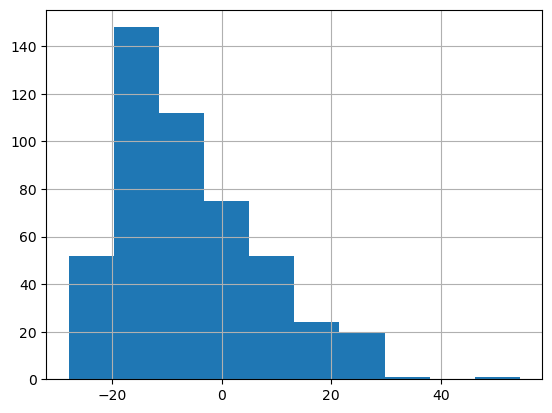

In [44]:
qh.Val.hist()

<AxesSubplot:>

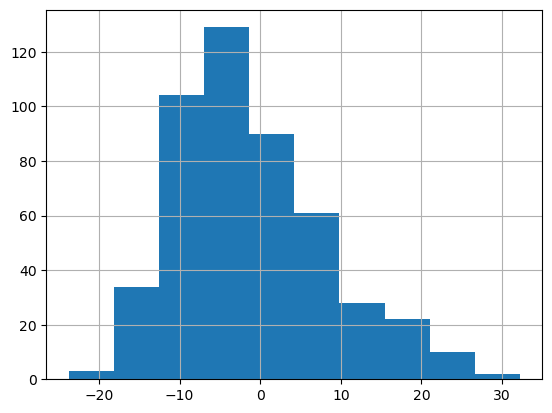

In [45]:
qp.Val.hist()

In [49]:
df = pd.read_sql('SELECT * FROM players', engine)

In [52]:
df['surplus'] = df['Value'] - df['CBS']

In [56]:
df

,index,playerid,AB,G,H,HR,PA,R,RBI,SB,Name,Team,Pos,Primary_Pos,Dollars,CBS,sorter,BA,CBSNAME,zR,zHR,zRBI,zSB,zBA,BIGAA,Pos_adj,z,Value,BB,ER,GS,HA,HLD,IP,SO,SV,Sv+Hld,W,ERA,WHIP,zSO,zW,zSv+Hld,zERA,zWHIP,Outs,K/9,Timestamp,Paid,Owner,Used,surplus
0,0,15640,554.0,150,156.0,43.0,659.0,106.0,106.0,9.0,Aaron Judge,NYY,OF/DH,OF,40.820435,41.0,420.666667,0.281250,Aaron Judge,2.074951,2.570905,1.954326,0.137249,0.990868,7.728299,1.781785,9.510084,47.041793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None,None,6.041793
1,1,19611,580.0,151,169.0,36.0,657.0,97.0,105.0,5.0,Vladimir Guerrero,TOR,1B/DH,1B,38.588283,34.0,414.000000,0.291212,Vladimir Guerrero,1.571874,1.846890,1.904972,-0.352625,1.431068,6.402180,2.151733,8.553913,42.312074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None,None,8.312074
2,2,18401,554.0,145,150.0,30.0,648.0,104.0,80.0,33.0,Ronald Acuna,ATL,OF/DH,OF,38.480032,39.0,398.666667,0.271034,Ronald Acuna,1.963156,1.226307,0.671108,3.076493,0.574895,7.511958,1.781785,9.293744,45.971661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None,None,6.971661
3,3,23697,577.0,147,159.0,29.0,643.0,93.0,81.0,23.0,Julio Rodriguez,SEA,OF,OF,35.327956,40.0,387.666667,0.276141,Julio Rodriguez,1.348284,1.122876,0.720463,1.851808,0.790981,5.834412,1.781785,7.616197,37.673649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None,None,-2.326351
4,4,20123,525.0,151,146.0,31.0,666.0,106.0,91.0,8.0,Juan Soto,SDP,OF,OF,34.649926,37.0,384.666667,0.279188,None,2.074951,1.329737,1.214008,0.014781,0.811855,5.445332,1.781785,7.227117,35.749058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,None,None,-1.250942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,558,15038,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,German Marquez,COL,SP,SP,-20.696189,0.0,166.333333,NaN,German Marquez,NaN,NaN,NaN,NaN,NaN,-4.485799,1.813179,-2.672621,-13.220163,62.0,100.0,31.0,198.0,0.0,183.333333,156.0,0.0,0.0,9.0,4.909091,1.418182,1.012319,0.541989,-1.05048,-2.680293,-2.309334,550.0,7.658182,None,0,None,None,-13.220163
1169,559,19268,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,Justin Dunn,CIN,SP,SP,-25.423594,0.0,71.333333,NaN,Justin Dunn,NaN,NaN,NaN,NaN,NaN,-6.682695,1.813179,-4.869516,-24.087143,44.0,60.0,17.0,95.0,0.0,87.666667,68.0,0.0,0.0,3.0,6.159696,1.585551,-0.646572,-0.823020,-1.05048,-2.325927,-1.836694,263.0,6.980989,None,0,None,None,-24.087143
1170,560,15488,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,Antonio Senzatela,COL,SP,SP,-27.066684,0.0,87.333333,NaN,Antonio Senzatela,NaN,NaN,NaN,NaN,NaN,-6.200384,1.813179,-4.387205,-21.701385,36.0,79.0,25.0,170.0,0.0,138.000000,80.0,0.0,0.0,6.0,5.152174,1.492754,-0.420360,-0.140516,-1.05048,-2.337042,-2.251986,414.0,5.217391,None,0,None,None,-21.701385
1171,561,11589,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,Jose Urena,COL,SP,SP,-27.475370,0.0,79.333333,NaN,Jose Urena,NaN,NaN,NaN,NaN,NaN,-7.005334,1.813179,-5.192155,-25.683085,48.0,73.0,22.0,139.0,0.0,116.666667,74.0,0.0,0.0,5.0,5.631429,1.602857,-0.533466,-0.368017,-1.05048,-2.508319,-2.545052,350.0,5.708571,None,0,None,None,-25.683085


In [64]:
df[df['Pos'].str.contains('SP')].sort_values('surplus', ascending=False)[['Name', 'Pos', 'CBS', 'Value', 'surplus']].head(25)

,Name,Pos,CBS,Value,surplus
621,Aaron Nola,SP,0.0,24.117663,24.117663
610,Jacob deGrom,SP,25.0,33.562858,8.562858
620,Tyler Glasnow,SP,12.0,20.398310,8.398310
637,Andrew Heaney,SP,1.0,9.282787,8.282787
668,Pablo LÃÂ³pez,SP,0.0,7.341382,7.341382
612,Carlos Rodon,SP,23.0,30.178420,7.178420
656,Jordan Montgomery,SP,1.0,6.529007,5.529007
655,Alex Cobb,SP,1.0,6.031299,5.031299
611,Gerrit Cole,SP,27.0,31.417930,4.417930
676,Drew Rasmussen,SP,2.0,6.369650,4.369650
